In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=12)  # Set default font size for all elements
plt.rc('axes', titlesize=16)  # Title font size
plt.rc('axes', labelsize=14)  # X and Y labels font size
plt.rc('xtick', labelsize=12)  # X tick labels font size
plt.rc('ytick', labelsize=12)  # Y tick labels font size
plt.rc('legend', fontsize=10)  # Legend font size
plt.rc('figure', titlesize=12)  # Figure title font size

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
# csv_file_rn = "/home/lgierz/BA_MothClassification/data/status/hyperparameter_tuning_resnet_chunky.csv"
# csv_file135knn_rn = "/home/lgierz/BA_MothClassification/data/status/hyperparameter_tuning_resnet_chunky_additional135knn.csv"

# csv_file_din = "/home/lgierz/BA_MothClassification/data/status/hyperparameter_tuning_dino_chunky.csv"
# csv_file135knn_din = "/home/lgierz/BA_MothClassification/data/status/hyperparameter_tuning_dino_chunky_additional135knn.csv"
# # Load the CSV file into a DataFrame
# dfrn1 = pd.read_csv(csv_file_rn)
# dfrn135knn = pd.read_csv(csv_file135knn_rn)

# dfdin1 = pd.read_csv(csv_file_din)
# dfdin135knn = pd.read_csv(csv_file135knn_din)

# df1 = pd.concat([dfrn1, dfrn135knn])
# df2 = pd.concat([dfdin1, dfdin135knn])
# df1['FoundationalModel'] = 'ResNet50'
# df1['Reducer_FoundationalModel'] = df1['Method'] + ' - ' + df1['FoundationalModel']

# df2['FoundationalModel'] = 'DINOv2'
# df2['Reducer_FoundationalModel'] = df2['Method'] + ' - ' + df2['FoundationalModel']

# df = pd.concat([df1, df2])

In [5]:
df = pd.read_csv("/home/lgierz/BA_MothClassification/data/status/preliminary_results.csv")

### Comparison between UMAP and PCA

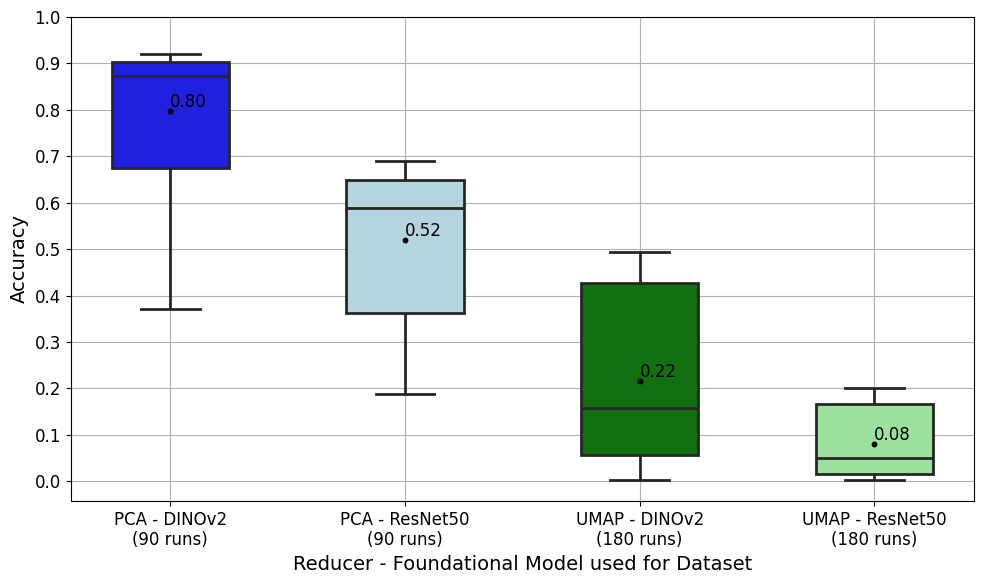

In [9]:
import seaborn as sns

# Create a new column for the combination of Reducer and FoundationalModel


# Calculate the mean accuracy for each Reducer_FoundationalModel
mean_accuracy = df.groupby('Reducer_FoundationalModel')['Accuracy'].mean().sort_values(ascending=False)

# Calculate the number of runs for each Reducer_FoundationalModel
run_counts = df['Reducer_FoundationalModel'].value_counts()

#print(mean_accuracy)

# Define colors
colors = {
    'PCA - ResNet50': 'lightblue',
    'PCA - DINOv2': 'blue',
    'UMAP - ResNet50': 'lightgreen',
    'UMAP - DINOv2': 'green'
}

# Create the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Reducer_FoundationalModel', y='Accuracy', data=df, order=mean_accuracy.index, palette=colors, width=0.5, linewidth=2)

# Add mean points to the boxplot
for i, (name, mean) in enumerate(mean_accuracy.items()):
    plt.scatter(i, mean, color='black', s=10, zorder=10)
    plt.text(i, mean, f'{mean:.2f}', color='black', ha='left', va='bottom', fontsize=12)

# Update x-tick labels to include the number of runs
xtick_labels = [f'{name}\n({run_counts[name]} runs)' for name in mean_accuracy.index]
ax.set_xticklabels(xtick_labels)#, rotation=45, ha='right')

plt.yticks(np.arange(0, 1.05, 0.1))
plt.ylabel('Accuracy')
plt.xlabel('Reducer - Foundational Model used for Dataset')
plt.grid(True)

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors.values()]
labels = colors.keys()
#plt.legend(handles, labels, title="Reducer - Foundational Model", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
for method in ['UMAP', 'PCA']:
    subset_df = df[df['Method'] == method]['Reduction Time (s)']
    avg = subset_df.mean()
    print(f'The Average reduction time of {method} is {avg//60:.0f}:{avg%60:.0f} min')

The Average reduction time of UMAP is 25:11 min
The Average reduction time of PCA is 0:23 min


### Further analysis of PCA  results (chosen method)

In [11]:
pca_results_df = df[df['Method'] == 'PCA']

##### Analysing Linear Classifier Results

In [12]:
linear_df = pca_results_df[pca_results_df['Model'] == 'Linear Classifier']
linear_df = linear_df[['FoundationalModel', 'Parameters', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Learning Rate', 'Epochs', 'Epoch Losses', 'Epoch Accuracies']].reset_index()

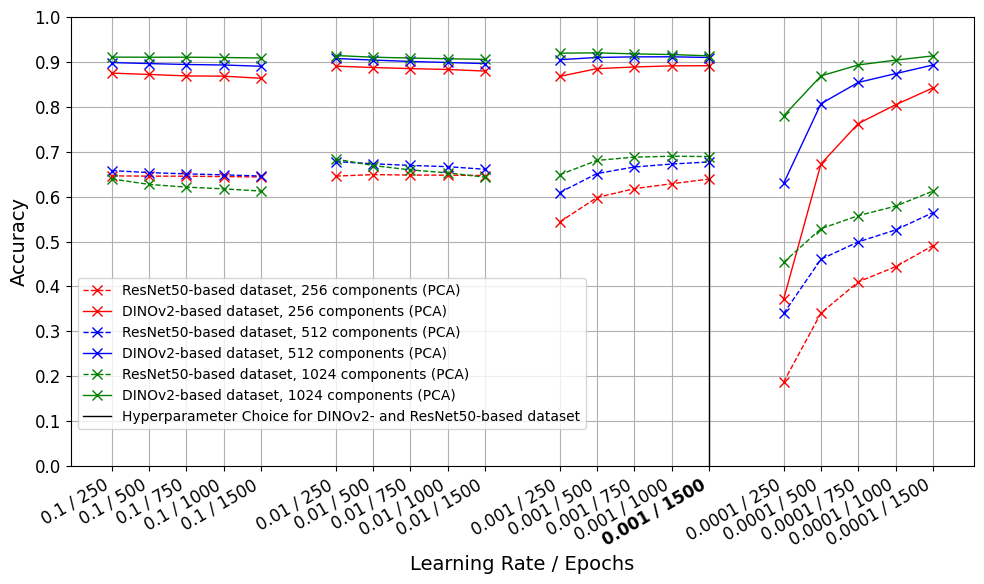

In [16]:
import numpy as np

# Define colors for the models
colors = {
    '256': 'red',
    '512': 'blue',
    '1024': 'green'
}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the lines for each combination of components and foundational models
for components, color in colors.items():
    for model in ['ResNet50', 'DINOv2']:
        subset = linear_df[(linear_df['Parameters'] == f"{{'n_components': {components}, 'random_state': 42}}") & 
                 (linear_df['FoundationalModel'] == model)].sort_values(['Learning Rate', 'Epochs'], ascending=[False, True])
        
        # Create breaks between different learning rates
        accuracies = []
        x_positions = []
        current_pos = 0
        
        for lr in sorted(subset['Learning Rate'].unique(), reverse=True):
            lr_data = subset[subset['Learning Rate'] == lr]
            accuracies.extend(lr_data['Accuracy'].tolist())
            accuracies.append(np.nan)  # Add NaN to create break
            x_positions.extend(range(current_pos, current_pos + len(lr_data)))
            x_positions.append(current_pos + len(lr_data))
            current_pos += len(lr_data) + 1

        # Remove the last NaN value
        accuracies = accuracies[:-1]
        x_positions = x_positions[:-1]
        
        ax.plot(x_positions, accuracies,
                label=f'{model}-based dataset, {components} components (PCA)',
                marker='x',
                color=color,
                linestyle='-' if model == 'DINOv2' else '--',
                linewidth=1,
                markersize=7)

# X-axis labels
xtick_positions = []
xtick_labels = []
current_pos = 0

for lr in sorted(linear_df['Learning Rate'].unique(), reverse=True):
    for ep in sorted(linear_df['Epochs'].unique()):
        xtick_positions.append(current_pos)
        xtick_labels.append(f'{lr} / {int(ep)}')
        current_pos += 1
    current_pos += 1  # Add space for the break

ax.set_xticks(xtick_positions[:])  # Remove last position which is extra
ax.set_xticklabels(xtick_labels[:], rotation=30, ha='right')

# Add vertical lines and create line objects for legend
dino_line = plt.axvline(x=xtick_positions[xtick_labels.index('0.001 / 1500')], color='black', linestyle='-', linewidth=1, label='Hyperparameter Choice for DINOv2- and ResNet50-based dataset')

# Make corresponding tick labels bold
for label in ['0.001 / 1500']:
    idx = xtick_labels.index(label)
    ax.get_xticklabels()[idx].set_fontweight('bold')

# Labels and title
ax.set_xlabel('Learning Rate / Epochs')
ax.set_ylabel('Accuracy')

# Legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='center left', bbox_to_anchor=(0, 0.25))
plt.yticks(np.arange(0, 1.05, 0.1))
plt.tight_layout()
plt.grid()
plt.show()


In [12]:
linear_df[['Parameters', 'Training Time (s)', 'Accuracy', 'Learning Rate', 'Epochs']].sort_values(by='Accuracy', ascending=False).head(10)

,Parameters,Training Time (s),Accuracy,Learning Rate,Epochs
106,"{'n_components': 1024, 'random_state': 42}",16.49,0.9202,0.0010,500.0
102,"{'n_components': 1024, 'random_state': 42}",8.09,0.9194,0.0010,250.0
110,"{'n_components': 1024, 'random_state': 42}",24.78,0.9179,0.0010,750.0
114,"{'n_components': 1024, 'random_state': 42}",32.99,0.9164,0.0010,1000.0
101,"{'n_components': 1024, 'random_state': 42}",8.04,0.9142,0.0100,250.0
118,"{'n_components': 1024, 'random_state': 42}",49.37,0.9135,0.0010,1500.0
119,"{'n_components': 1024, 'random_state': 42}",49.01,0.9134,0.0001,1500.0
94,"{'n_components': 512, 'random_state': 42}",21.78,0.9114,0.0010,1000.0
90,"{'n_components': 512, 'random_state': 42}",16.34,0.9112,0.0010,750.0
100,"{'n_components': 1024, 'random_state': 42}",7.98,0.9107,0.1000,250.0


In [10]:
linear_df['Parameters'].unique()

array(["{'n_components': 256, 'random_state': 42}",
       "{'n_components': 512, 'random_state': 42}",
       "{'n_components': 1024, 'random_state': 42}"], dtype=object)

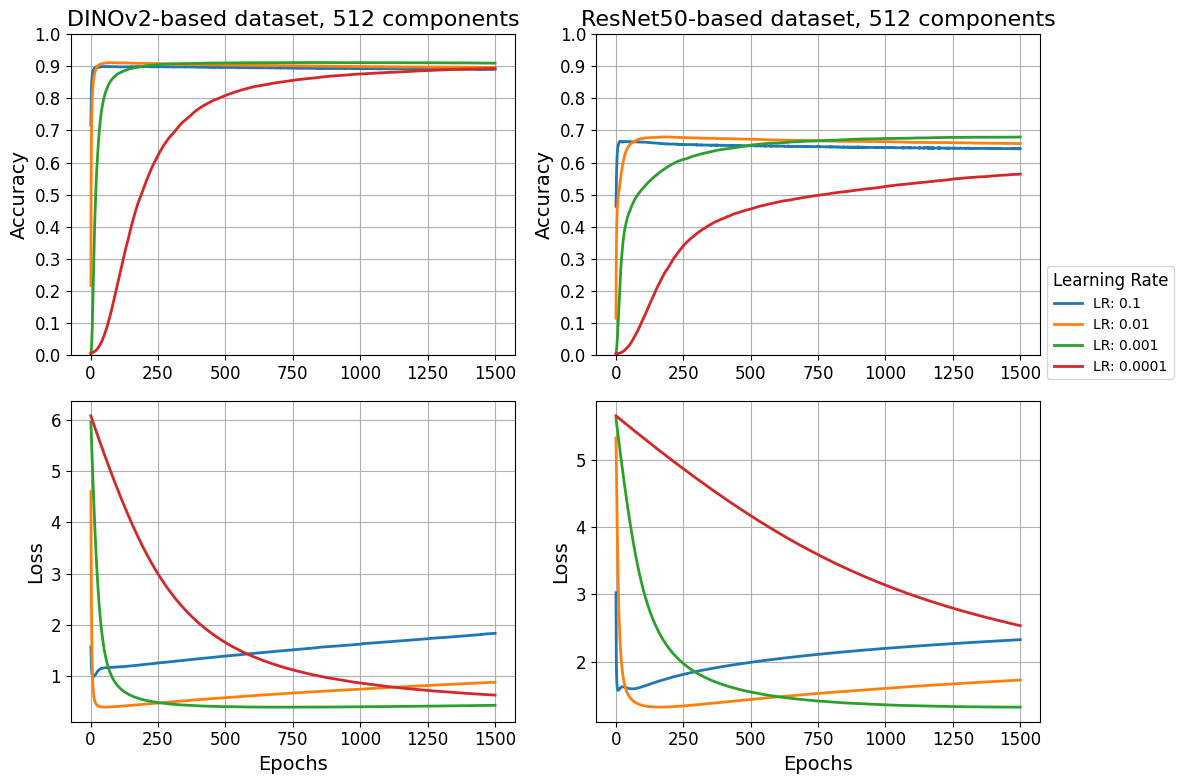

In [35]:
# Create the plot
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot accuracy for DINO
for i, row in dino_df.iterrows():
    epoch_accuracies = eval(row['Validation Accuracies'])
    epochs = range(1, len(epoch_accuracies) + 1)
    ax1.plot(epochs, epoch_accuracies, label=f'LR: {row["Learning Rate"]}', linewidth=2)

# Plot loss for DINO
for i, row in dino_df.iterrows():
    epoch_losses = eval(row['Validation Losses'])
    epochs = range(1, len(epoch_losses) + 1)
    ax2.plot(epochs, epoch_losses, label=f'LR: {row["Learning Rate"]}', linewidth=2)

# Plot accuracy for ResNet50
for i, row in resnet_df.iterrows():
    epoch_accuracies = eval(row['Validation Accuracies'])
    epochs = range(1, len(epoch_accuracies) + 1)
    ax3.plot(epochs, epoch_accuracies, label=f'LR: {row["Learning Rate"]}', linewidth=2)

# Plot loss for ResNet50
for i, row in resnet_df.iterrows():
    epoch_losses = eval(row['Validation Losses'])
    epochs = range(1, len(epoch_losses) + 1)
    ax4.plot(epochs, epoch_losses, label=f'LR: {row["Learning Rate"]}', linewidth=2)

# Labels and title for DINO
ax1.set_title('DINOv2-based dataset, 512 components')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

# Labels and title for ResNet50
ax3.set_title('ResNet50-based dataset, 512 components')
ax3.set_ylabel('Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')

# Set y-axis limits and grid for accuracy plots
ax1.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax1.grid(True)
ax3.grid(True)
ax1.set_yticks(np.arange(0, 1.05, 0.1))
ax3.set_yticks(np.arange(0, 1.05, 0.1))

# Set grid for loss plots
ax2.grid(True)
ax4.grid(True)

# Add legend
ax3.legend(title='Learning Rate', loc='center left', bbox_to_anchor=(1.0, 0.1))

plt.tight_layout()
plt.show()


##### Analysing KNN Results

In [38]:
knn_df = pca_results_df[pca_results_df['Model'] == 'KNN'].sort_values(['Parameters', 'Neighbors'])
knn_df = knn_df[['FoundationalModel', 'Parameters', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Neighbors']].reset_index()

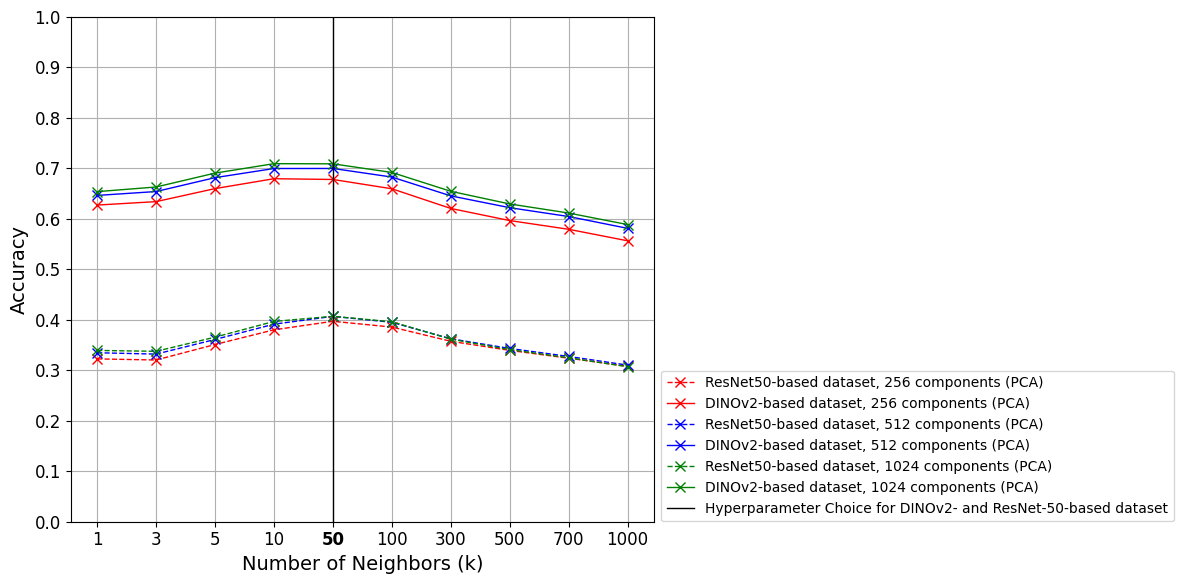

In [60]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the lines for each combination of components and foundational models
for components, color in colors.items():
    for model in ['ResNet50', 'DINOv2']:
        subset = knn_df[(knn_df['Parameters'] == f"{{'n_components': {components}, 'random_state': 42}}") & 
                       (knn_df['FoundationalModel'] == model)]
        
        # Convert Neighbors to categorical x values
        x = range(len(subset))
        ax.plot(x, subset['Accuracy'].values,
                label=f'{model}-based dataset, {components} components (PCA)',
                marker='x',
                color=color,
                linestyle='-' if model == 'DINOv2' else '--',
                linewidth=1,
                markersize=7)

# Labels and title
ax.set_xlabel('Number of Neighbors (k)')
ax.set_ylabel('Accuracy')

# Set x-ticks to match the actual neighbor values
neighbors = sorted(knn_df['Neighbors'].unique())
ax.set_xticks(range(len(neighbors)))
ax.set_xticklabels([str(int(x)) for x in neighbors])

# Highlight k=50 with a vertical line and bold text
k50_index = list(neighbors).index(50)
line = ax.axvline(x=k50_index, color='black', linestyle='-', linewidth=1, 
                  label='Hyperparameter Choice for DINOv2- and ResNet-50-based dataset')
for i, label in enumerate(ax.get_xticklabels()):
    if i == k50_index:
        label.set_fontweight('bold')

# Legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='center left', bbox_to_anchor=(1, 0.15))

# Set y-axis ticks from 0 to 1 with 0.1 intervals
plt.yticks(np.arange(0, 1.05, 0.1))

plt.tight_layout()
plt.grid()
plt.show()


In [18]:
# Filter the DataFrame for PCA results
df_lin = df[(df['Method'] == 'PCA') & (df['Model'] == 'Linear Classifier') & (df['Epochs'] == 1500)]
df_knn = df[(df['Method'] == 'PCA') & (df['Model'] == 'KNN')]

new_df = pd.concat([df_lin, df_knn])
# Calculate the average training time for each class
average_training_time = new_df.groupby(new_df['Parameters'].apply(lambda x: eval(x)['n_components']))['Training Time (s)'].mean()

# Print the results
print('Average Logistic Regression Training Time for 1500 Epochs and KNN')
print(average_training_time)


Average Logistic Regression Training Time for 1500 Epochs and KNN
Parameters
256     17.974286
512     29.433929
1024    53.085000
Name: Training Time (s), dtype: float64


### Further Linear Classifier Tests with LR Scheduling based on results
- 512 and 1024 Components

In [19]:
csv_file_LRscheduler = "/home/lgierz/BA_MothClassification/data/status/hyperparameter_tuning_resnet_chunky_additionalOOPLRscheduler.csv"
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_LRscheduler)
df = df[['Parameters', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Learning Rate', 'Epochs', 'Gamma', 'Patience', 'Epoch Losses', 'Epoch Accuracies']].reset_index()
df[['Parameters', 'Training Time (s)','Accuracy', 'Learning Rate', 'Epochs', 'Gamma', 'Patience']].sort_values(by='Accuracy', ascending=False).head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lgierz/BA_MothClassification/data/status/hyperparameter_tuning_resnet_chunky_additionalOOPLRscheduler.csv'

#### Results for 1024 Components

In [ ]:
from itertools import product

df1024 = df[df['Parameters'] == "{'n_components': 1024, 'random_state': 42}"]
# Create the plot

colors = ['red', 'green', 'blue', 'black']

def generate_combinations(*args):
    return list(product(*args))

# Define the ranges for gamma, learning rate, epochs, and patience
gammas = [0.2, 0.5, 0.8, 0.95]
lrs = [0.01, 0.001]
epochs = [1000, 1500]
patiences = [3, 5, 10]

# Generate the combinations
combinations = generate_combinations(epochs)

# Plot the line plots

fig, axs = plt.subplots(len(combinations)//2, 2, figsize=(18, 36))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, epochs in enumerate([1000,1500]):
    runs = df1024[(df1024['Epochs'] == epochs)].reset_index() # (df1024['Learning Rate'] == lr) & 
    print(len(runs))
    #ax = axs[idx//2, idx%2]
    ax = axs[idx]
    for i, run in runs.iterrows():
        epoch_losses = eval(run['Epoch Losses'])  # Eval for list of losses
        epoch_losses_max = max(epoch_losses)
        epoch_losses = [loss / epoch_losses_max for loss in epoch_losses]
        epoch_accuracies = eval(run['Epoch Accuracies'])  # Eval for list of accuracies
        
        ax.plot(epoch_losses, linestyle='--', label=f'Loss G:{run["Gamma"]}_P:{run["Patience"]}', color=colors[i%4])
        ax.plot(epoch_accuracies, label=f'Acc G:{run["Gamma"]}_P:{run["Patience"]}', color=colors[i%4])
        if i == 0:
            ax.set_title(f'LR: {run["Learning Rate"]}, Epochs: {run["Epochs"]}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy & Loss')
    ax.legend()

plt.tight_layout()
plt.show()



#### Results for 512 Components

In [ ]:
df512 = df[df['Parameters'] == "{'n_components': 512, 'random_state': 42}"]
# Create the plot
fig, axs = plt.subplots(6, 2, figsize=(18, 36))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

colors = ['red', 'green', 'blue', 'black']


# Plot the line plots
for idx, (gamma, patience) in enumerate([(0.2, 3), (0.5, 3), (0.8, 3), (0.95, 3), (0.2, 5), (0.5, 5), (0.8, 5), (0.95, 5), (0.2, 10), (0.5, 10), (0.8, 10), (0.95, 10)]):
    runs = df512[(df512['Gamma'] == gamma) & (df512['Patience'] == patience)].reset_index()
    ax = axs[idx//2, idx%2]
    for i, run in runs.iterrows():
        epoch_losses = eval(run['Epoch Losses'])  # Eval for list of losses
        epoch_losses_max = max(epoch_losses)
        epoch_losses = [loss / epoch_losses_max for loss in epoch_losses]
        epoch_accuracies = eval(run['Epoch Accuracies'])  # Eval for list of accuracies
        
        ax.plot(epoch_losses, linestyle='--', label=f'Loss {run["Learning Rate"]}_{run["Epochs"]}', color=colors[i%4])
        ax.plot(epoch_accuracies, label=f'Acc {run["Learning Rate"]}_{run["Epochs"]}', color=colors[i%4])
    
    ax.set_title(f'Gamma: {gamma}, Patience: {patience}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy & Loss')
    ax.legend()

plt.tight_layout()
plt.show()

